# CATE Estimation Disparity Between Minority and Majority Groups

In [1]:
# imports
import time
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import econml
from econml.grf import CausalForest
from RATE import *
# set numpy seed
np.random.seed(0)

In [2]:
NUM_SIMULATIONS = 50  # global constant for number of simulations

In [3]:
global_start_time = time.time()

## Simulated Data Generation

Simulate a dataset where a protected variable is imbalanced. The other confonders include categorical and continuous covariates. The treatment is randomly assigned and the treatment effect is locally linear. We want the CATE function to share similarities between the majority and minority groups but are also slightly different. The reason is that if the CATE functions are identical across the board, then only training on the majority group makes it correct on the minority group also.

In [4]:
def gen_imbalanced_data_locallinearTE(n=4000, propensity=0.5, p_protect=0.01, m_categorical=2, m_continuous=3, noise_var=1.0):
    # imbalanced protected variable
    X_protect = np.random.choice([0,1], size=(n, 1), p=[1-p_protect, p_protect])
    # some categorical
    X_categorical = np.random.choice([0,1], size=(n, m_categorical), p=[0.5, 0.5])
    # some continuous
    X_continuous = np.random.normal(0, 1, size=(n, m_continuous))
    # m = 1+m_categorical+m_continuous
    X = np.concatenate((X_protect, X_categorical, X_continuous), axis=1)
    # random treatment assignment
    W = np.random.choice([0,1], n, p=[1-propensity, propensity])
    # if the treatment effect is linear, then the linear model is correctly specified
    Tau = X_protect[:,0] + X_categorical[:,0] + X_continuous[:,0] + (1-X_protect[:, 0]) * X_continuous[:,1]
    Y = np.maximum(np.sum(X, axis=1), 0.0) + W * Tau + np.random.normal(0, np.sqrt(noise_var), n)
    return X, W, Tau, Y

In [5]:
X_train, W_train, Tau_train, Y_train = gen_imbalanced_data_locallinearTE()
X_test, W_test, Tau_test, Y_test = gen_imbalanced_data_locallinearTE(n=1000)
# sanity check:
# shapes, should expect 4000x6, 4000, 4000, and 4000
print(X_train.shape, W_train.shape, Tau_train.shape, Y_train.shape)
# should expect numbers close to 0.01, 0.5, and 0
print(np.sum(X_train[:,0]) / len(X_train), np.sum(W_train) / len(W_train), np.sum(X_train[:,-1]) / len(X_train))
print("Some examples of Y:", Y_train[:5])

(4000, 6) (4000,) (4000,) (4000,)
0.0095 0.5035 0.0024762748821773543
Some examples of Y: [ 3.62390273 -0.88107614  1.2770569   0.62550069  0.78849849]


In [6]:
print(np.mean(Tau_train)) # has an expectation of 0.6

0.5326887646867717


### Graphing

In [7]:
def eval_MSE_twoGroups(CATE_pred, X, Tau, verbose = False):
    # minority group performance
    if len(np.where(X[:,0] == 1)[0]) != 0:
        CATE_pred_minority = CATE_pred[X[:,0] == 1]
        Tau_minority = Tau[X[:,0] == 1]
        MSE_minority = mean_squared_error(Tau_minority, CATE_pred_minority)
    else:
        MSE_minority = 0.0
    # majority group performance
    if len(np.where(X[:,0] == 0)[0]) != 0:
        CATE_pred_majority = CATE_pred[X[:,0] == 0]
        Tau_majority = Tau[X[:,0] == 0]
        MSE_majority = mean_squared_error(Tau_majority, CATE_pred_majority)
    else:
        MSE_majority = 0.0
    
    MSE_diff = MSE_minority - MSE_majority
    
    if verbose:
        print(f"The MSE on minority group is {MSE_minority: .3f}. The MSE on majority group is {MSE_majority: .3f}. The difference is {MSE_diff: .3f}.")
    return MSE_minority, MSE_majority, MSE_diff 

In [20]:
# generate a 2 by 2 plot.
# 2 plots are how ratio in the two MSEs changes with weight on minority group for training and testing sets
# the other 2 are "ROC curves with MSE on minority group against MSE on majority group"

def plot_MSE(mu_list, train_min, train_maj, train_diff, test_min, test_maj, test_diff, 
             name=None, custom_xticks=None, custom_yticks=None, min_MSE=0, max_MSE=1.5, optimal_points = None):
    
    plt.figure(figsize=(10,8))
    
    # plot ratio of MSE with respect to weight on minority (Train)
    plt.subplot(2, 2, 1)
    scatter_1 = plt.scatter(mu_list, np.array(train_min) / np.array(train_maj), c=mu_list, cmap='viridis', s=np.array(mu_list)/8+3)
    plt.yscale('log')
    plt.colorbar(scatter_1, label='weight on minority group')
    plt.axvline(x=1, color="grey", linestyle='--')
    plt.axhline(y=1.0, color="grey", linestyle='--')
    plt.xlabel('Weight on minority group')
    plt.ylabel('Minority group MSE / Majority group MSE')
    if custom_xticks is None:
        custom_xticks = [i*8 for i in range(11)] # Custom x-axis tick locations
    if custom_yticks is None:
        custom_yticks = [1e-1, 1e0, 1e1, 1e2] # Custom y-axis tick locations
    plt.xticks(custom_xticks)
    plt.yticks(custom_yticks)
    plt.title('MSE_ratio vs. weight on minority group (Train)')
    
    #  plot ratio of MSE with respect to weight on minority (Test)
    plt.subplot(2, 2, 2)
    scatter_2 = plt.scatter(mu_list, np.array(test_min) / np.array(test_maj), c=mu_list, cmap='viridis', s=np.array(mu_list)/8+3)
    plt.yscale('log')
    plt.colorbar(scatter_2, label='weight on minority group')
    plt.axvline(x=1, color="grey", linestyle='--')
    plt.axhline(y=1.0, color="grey", linestyle='--')
    plt.xlabel('Weight on minority group')
    plt.ylabel('Minority group MSE / Majority group MSE')
    if custom_xticks is None:
        custom_xticks = [i*8 for i in range(11)] # Custom x-axis tick locations
    if custom_yticks is None:
        custom_yticks = [1e-1, 1e0, 1e1, 1e2] # Custom y-axis tick locations
    plt.xticks(custom_xticks)
    plt.yticks(custom_yticks)
    plt.title('MSE_ratio vs. weight on minority group (Test)')
    
    # plot MSE on majority vs. on minority (Train)
    plt.subplot(2, 2, 3)
    # smaller circles indicate smaller weight
    scatter_3 = plt.scatter(train_min, train_maj, c=mu_list, cmap='viridis', s=np.array(mu_list)/8+3)
    if optimal_points is not None:
        plt.scatter(optimal_points[0], optimal_points[1], color='red', marker='o', s=15, label = "Optimal MSEs")
    plt.colorbar(scatter_3, label='weight on minority group')
    plt.plot(np.linspace(min_MSE, max_MSE, 100), np.linspace(min_MSE, max_MSE, 100), linestyle='--', color='grey')
    plt.xlabel('MSE on minority group')
    plt.ylabel('MSE on majority group')
    plt.axis('equal')
    plt.title('MSE on majority group vs. minority group (Train)')
    if optimal_points is not None:
        plt.legend(loc='upper left')
    
    # plot MSE on majority vs. on minority (Test)
    plt.subplot(2, 2, 4)
    # smaller circles indicate smaller weight
    scatter_4 = plt.scatter(test_min, test_maj, c=mu_list, cmap='viridis', s=np.array(mu_list)/8+3)
    if optimal_points is not None:
        plt.scatter(optimal_points[2], optimal_points[3], color='red', marker='o', s=15, label = "Optimal MSEs")
    plt.colorbar(scatter_4, label='weight on minority group')
    plt.plot(np.linspace(min_MSE, max_MSE, 100), np.linspace(min_MSE, max_MSE, 100), linestyle='--', color='grey')
    plt.xlabel('MSE on minority group')
    plt.ylabel('MSE on majority group')
    plt.axis('equal')
    plt.title('MSE on majority group vs. minority group (Test)')
    if optimal_points is not None:
        plt.legend(loc='upper left')
    
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, dpi=200)
    plt.show()

## Doubly Robust Pseudo-outcome

In [9]:
# TODO: check if reweighting is done this way!
# Change to AIPW since randomized control
def DR_linear_estimator(X, W, Y, weight_minority=1.0):
    sample_weights = X[:,0] * (weight_minority-1.0) + 1.0
    # propensity = LinearRegression(n_jobs=-1)
    # control_nuissance = LinearRegression(n_jobs=-1)
    # treatment_nuissance = LinearRegression(n_jobs=-1)
    
    # use non-parametric for nuissance
    # control_nuissance = econml.grf.RegressionForest(n_estimators=200)
    # treatment_nuissance = econml.grf.RegressionForest(n_estimators=200)

    # propensity.fit(X, W, sample_weight = sample_weights)
    # control_nuissance.fit(X[W==0], Y[W==0], sample_weight = sample_weights[W==0])
    # treatment_nuissance.fit(X[W==1], Y[W==1], sample_weight = sample_weights[W==1])
    # control_nuissance.fit(X[W==0], Y[W==0])
    # treatment_nuissance.fit(X[W==1], Y[W==1])

    # pseudo_outcome_Y = treatment_nuissance.predict(X) - control_nuissance.predict(X) + W*(Y-treatment_nuissance.predict(X))/propensity.predict(X) - (1-W)*(Y-control_nuissance.predict(X))/(1-propensity.predict(X))
    # pseudo_outcome_Y = treatment_nuissance.predict(X) - control_nuissance.predict(X) + W*(Y-treatment_nuissance.predict(X))/0.5 - (1-W)*(Y-control_nuissance.predict(X))/0.5
    # pseudo_outcome_Y = treatment_nuissance.predict(X).flatten() - control_nuissance.predict(X).flatten() + W*(Y-treatment_nuissance.predict(X).flatten())/0.5 - (1-W)*(Y-control_nuissance.predict(X).flatten())/0.5
    pseudo_outcome_Y = get_scores(X, Y, W, e=np.mean(W), m=None, params={'n_estimators': 200}, scoring_type="AIPW")
    
    model = LinearRegression(n_jobs=-1)
    model.fit(X, pseudo_outcome_Y, sample_weight = sample_weights)
    return model

In [10]:
model = DR_linear_estimator(X_train, W_train, Y_train)
CATE_pred = model.predict(X_train)
print(np.abs(CATE_pred - Tau_train))

[0.19928235 0.14062434 0.0530854  ... 0.05440865 0.17157188 0.06782795]


In [11]:
eval_MSE_twoGroups(CATE_pred, X_train, Tau_train, verbose = True)

The MSE on minority group is  1.008. The MSE on majority group is  0.014. The difference is  0.994.


(1.0077586627902528, 0.014172037439275417, 0.9935866253509774)

In [12]:
eval_MSE_twoGroups(model.predict(X_test), X_test, Tau_test, verbose = True)

The MSE on minority group is  1.185. The MSE on majority group is  0.014. The difference is  1.171.


(1.1852206079695438, 0.013778875449337213, 1.1714417325202064)

In [13]:
def run_DR_linear_simulation(num_simulations=NUM_SIMULATIONS, weight=1.0, p_protect=0.01, noise_var=1.0):
    MSE_minority_train, MSE_majority_train, MSE_diff_train = [], [], []
    MSE_minority_test, MSE_majority_test, MSE_diff_test = [], [], []
    for i in range(num_simulations):
        X_train, W_train, Tau_train, Y_train = gen_imbalanced_data_locallinearTE(p_protect=p_protect, noise_var=noise_var)
        X_test, W_test, Tau_test, Y_test = gen_imbalanced_data_locallinearTE(n=1000, p_protect=p_protect, noise_var=noise_var)
        model = DR_linear_estimator(X_train, W_train, Y_train, weight_minority=weight)
        # eval on train data
        MSE_minority, MSE_majority, MSE_diff = eval_MSE_twoGroups(model.predict(X_train), X_train, Tau_train)
        MSE_minority_train.append(MSE_minority)
        MSE_majority_train.append(MSE_majority)
        MSE_diff_train.append(MSE_diff)
        # eval on test data
        MSE_minority, MSE_majority, MSE_diff = eval_MSE_twoGroups(model.predict(X_test), X_test, Tau_test)
        MSE_minority_test.append(MSE_minority)
        MSE_majority_test.append(MSE_majority)
        MSE_diff_test.append(MSE_diff)
    return MSE_minority_train, MSE_majority_train, MSE_diff_train, MSE_minority_test, MSE_majority_test, MSE_diff_test

In [14]:
start_time = time.time()
MSE_minority_train, MSE_majority_train, MSE_diff_train, MSE_minority_test, MSE_majority_test, MSE_diff_test = run_DR_linear_simulation()
print("--- %s seconds ---" % (time.time() - start_time))
# stddev of sample mean is stddev of sample divided by sqrt(sample size)
# mean diff, stddev of mean diff, minimum diff, maximum diff
print(np.mean(MSE_diff_train), np.std(MSE_diff_train)/ np.sqrt(len(MSE_diff_train)), np.min(MSE_diff_train), np.max(MSE_diff_train))
print(np.mean(MSE_diff_test), np.std(MSE_diff_test)/ np.sqrt(len(MSE_diff_test)), np.min(MSE_diff_test), np.max(MSE_diff_test))

--- 55.77104163169861 seconds ---
1.3925620627801305 0.08988096673613205 0.6403744481845087 4.98314730977876
1.3520634306994423 0.08653258984277305 0.26513826589272227 3.08540044585465


In [15]:
mu_list = []
MSE_minority_train_list, MSE_majority_train_list, MSE_diff_train_list = [], [], []
MSE_minority_test_list, MSE_majority_test_list, MSE_diff_test_list = [], [], []
for i in range(1, 81):
    # mu in [1,80]
    mu_list.append(i)
    MSE_minority_train, MSE_majority_train, MSE_diff_train, MSE_minority_test, MSE_majority_test, MSE_diff_test = run_DR_linear_simulation(weight=i)
    MSE_minority_train_list.append(np.mean(MSE_minority_train))
    MSE_majority_train_list.append(np.mean(MSE_majority_train))
    MSE_diff_train_list.append(np.mean(MSE_diff_train))
    MSE_minority_test_list.append(np.mean(MSE_minority_test))
    MSE_majority_test_list.append(np.mean(MSE_majority_test))
    MSE_diff_test_list.append(np.mean(MSE_diff_test))

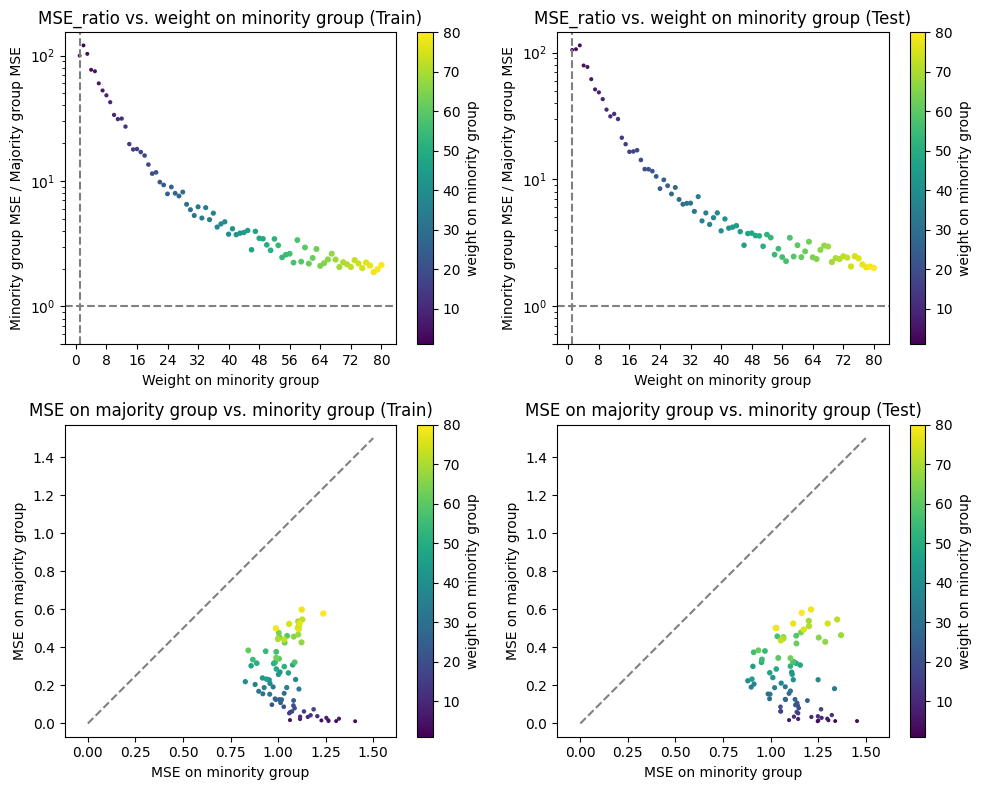

In [25]:
plot_MSE(mu_list, MSE_minority_train_list, MSE_majority_train_list, MSE_diff_train_list, 
         MSE_minority_test_list, MSE_majority_test_list, MSE_diff_test_list, 
         'locallinearTau_DRLearner_linearEstimator_MSEViz.png', max_MSE=1.5, custom_yticks = [5e-1, 1e0, 1e1, 1e2])

In [17]:
dr_save = [mu_list, MSE_minority_train_list, MSE_majority_train_list, MSE_diff_train_list, MSE_minority_test_list, MSE_majority_test_list, MSE_diff_test_list]


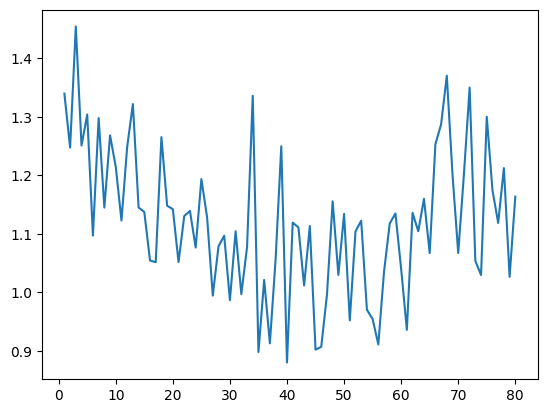

In [22]:
plt.plot(mu_list, MSE_minority_test_list)

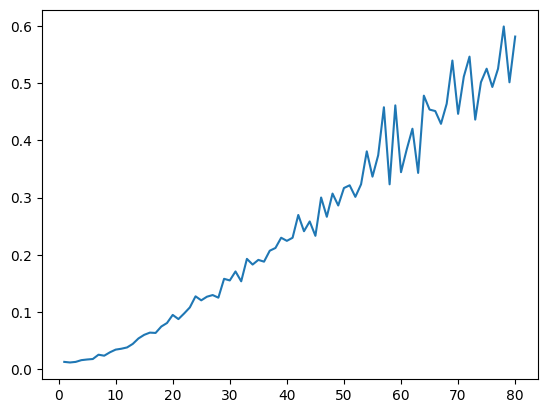

In [24]:
plt.plot(mu_list, MSE_majority_test_list)

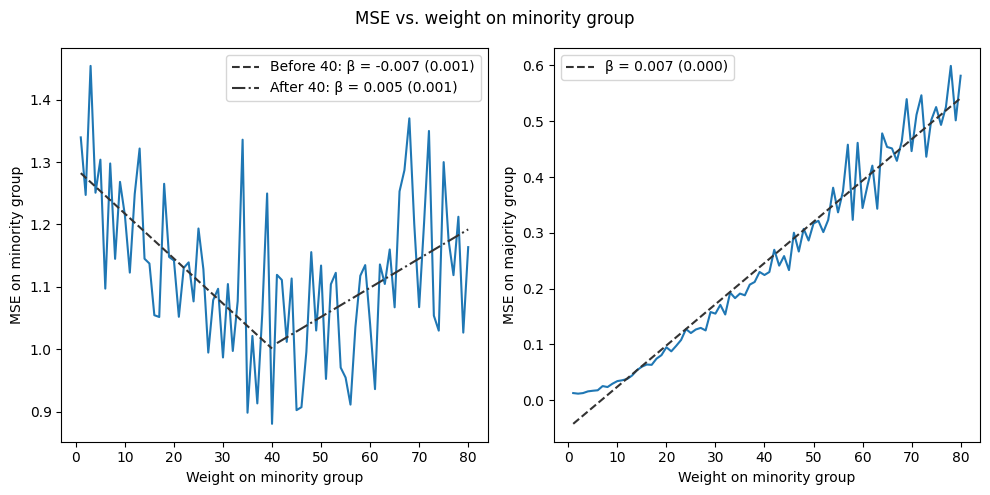

In [28]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(mu_list, MSE_minority_test_list)

idx = 40
x_first_half, y_first_half = mu_list[:idx], MSE_minority_test_list[:idx]
x_second_half, y_second_half = mu_list[idx:], MSE_minority_test_list[idx:]

# Fitting lines to the first and second halves of the data
coefficients_first_half, cov_first_half = np.polyfit(x_first_half, y_first_half, 1, cov=True)
coefficients_second_half, cov_second_half = np.polyfit(x_second_half, y_second_half, 1, cov=True)

# Generating the line equations
line_first_half = np.poly1d(coefficients_first_half)
line_second_half = np.poly1d(coefficients_second_half)

# Extracting standard deviation from the covariance matrix
std_dev_first_half = np.sqrt(np.diag(cov_first_half))[0]
std_dev_second_half = np.sqrt(np.diag(cov_second_half))[0]

# Plotting the lines of best fit for the first and second halves
color='#333333'
plt.plot(x_first_half, line_first_half(x_first_half), label=f'Before 40: β = {coefficients_first_half[0]:.3f} ({std_dev_first_half:.3f})', linestyle = '--', color=color)
plt.plot(x_second_half, line_second_half(x_second_half), label=f'After 40: β = {coefficients_second_half[0]:.3f} ({std_dev_second_half:.3f})', linestyle = '-.', color=color)
# plt.axvline(x=mu_list[idx], color='black', linestyle='-.')

# Adding text above each line with the beta coefficient
# plt.text((1+1+idx / 4)/2, line_first_half((1+1+idx / 4)/2)-10, f'slope: {coefficients_first_half[0]:.2f} ({std_dev_first_half:.2f})', fontsize=10, ha='center', color=color)
# plt.text((12+1+idx / 4)/2, line_second_half((12+1+idx / 4)/2)-10, f'slope: {coefficients_second_half[0]:.2f} ({std_dev_second_half:.2f})', fontsize=10, ha='center', color=color)

# plt.xticks([1.5,3.0,4.5,6,7.5,9,10.5,12])
plt.legend()
plt.xlabel('Weight on minority group')
plt.ylabel('MSE on minority group')

# second plot for majority
plt.subplot(1, 2, 2)
plt.plot(mu_list, MSE_majority_test_list)

coefficients_line, cov_line = np.polyfit(mu_list, MSE_majority_test_list, 1, cov=True)

# Generating the line equations
line = np.poly1d(coefficients_line)

# Extracting standard deviation from the covariance matrix
std_dev_line = np.sqrt(np.diag(cov_line))[0]

# Plotting the lines of best fit
plt.plot(mu_list, line(mu_list), label=f'β = {coefficients_line[0]:.3f} ({std_dev_line :.3f})', linestyle = '--', color=color)

# plt.xticks([1.5,3.0,4.5,6,7.5,9,10.5,12])
plt.legend()
plt.xlabel('Weight on minority group')
plt.ylabel('MSE on majority group')

fig.suptitle('MSE vs. weight on minority group') #  fontsize=16, y=1.05
plt.tight_layout()
plt.savefig("smallp_MSE_weight_best_fit", dpi=200)
plt.show()


## Causal Forest

In [29]:
def causalForest_estimator(X, W, Y, weight_minority=1.0, n_estimators=200):
    sample_weights = X[:,0] * (weight_minority-1.0) + 1.0
    model = CausalForest(n_estimators=n_estimators)
    model.fit(X, W, Y, sample_weight=sample_weights)
    return model

In [30]:
model = causalForest_estimator(X_train, W_train, Y_train)
CATE_pred = model.predict(X_train)[:,0]
print(np.abs(CATE_pred - Tau_train))
# seems reasonable

[0.50645621 0.7563796  0.13064224 ... 0.23130691 0.26779969 0.42676643]


In [31]:
eval_MSE_twoGroups(CATE_pred, X_train, Tau_train, verbose = True)

The MSE on minority group is  1.847. The MSE on majority group is  0.140. The difference is  1.706.


(1.8465237602441391, 0.14009588439884904, 1.70642787584529)

In [32]:
CATE_pred_test = model.predict(X_test)[:,0]
eval_MSE_twoGroups(CATE_pred_test, X_test, Tau_test, verbose = True)

The MSE on minority group is  2.245. The MSE on majority group is  0.161. The difference is  2.085.


(2.2452906829680233, 0.1607305122837036, 2.0845601706843198)

In [33]:
def run_causalForest_simulation(num_simulations=NUM_SIMULATIONS, weight=1.0, p_protect=0.01, noise_var=1.0, n=4000):
    MSE_minority_train, MSE_majority_train, MSE_diff_train = [], [], []
    MSE_minority_test, MSE_majority_test, MSE_diff_test = [], [], []
    for i in range(num_simulations):
        X_train, W_train, Tau_train, Y_train = gen_imbalanced_data_locallinearTE(n=n, p_protect=p_protect, noise_var=noise_var)
        X_test, W_test, Tau_test, Y_test = gen_imbalanced_data_locallinearTE(n=1000, p_protect=p_protect, noise_var=noise_var)
        model = causalForest_estimator(X_train, W_train, Y_train, weight_minority=weight)
        # eval on train data
        CATE_pred = model.predict(X_train)[:,0]
        MSE_minority, MSE_majority, MSE_diff = eval_MSE_twoGroups(CATE_pred, X_train, Tau_train)
        MSE_minority_train.append(MSE_minority)
        MSE_majority_train.append(MSE_majority)
        MSE_diff_train.append(MSE_diff)
        # eval on test data
        CATE_pred = model.predict(X_test)[:,0]
        MSE_minority, MSE_majority, MSE_diff = eval_MSE_twoGroups(CATE_pred, X_test, Tau_test)
        MSE_minority_test.append(MSE_minority)
        MSE_majority_test.append(MSE_majority)
        MSE_diff_test.append(MSE_diff)
    return MSE_minority_train, MSE_majority_train, MSE_diff_train, MSE_minority_test, MSE_majority_test, MSE_diff_test

In [35]:
MSE_minority_train, MSE_majority_train, MSE_diff_train, MSE_minority_test, MSE_majority_test, MSE_diff_test = run_causalForest_simulation()
# mean diff, stddev of mean diff, minimum diff, maximum diff
print(np.mean(MSE_diff_train), np.std(MSE_diff_train)/ np.sqrt(len(MSE_diff_train)), np.min(MSE_diff_train), np.max(MSE_diff_train))
print(np.mean(MSE_diff_test), np.std(MSE_diff_test)/ np.sqrt(len(MSE_diff_test)), np.min(MSE_diff_test), np.max(MSE_diff_test))

1.5490629076101579 0.04676427443932085 0.6174947434415818 2.42106742726899
1.597305260335583 0.07732963440588776 0.7420536913703177 3.0221608704337988


In [36]:
mu_list = []
MSE_minority_train_list, MSE_majority_train_list, MSE_diff_train_list = [], [], []
MSE_minority_test_list, MSE_majority_test_list, MSE_diff_test_list = [], [], []
start_time = time.time()
for i in range(1, 81):
    # mu in [1,80]
    mu_list.append(i)
    MSE_minority_train, MSE_majority_train, MSE_diff_train, MSE_minority_test, MSE_majority_test, MSE_diff_test = run_causalForest_simulation(weight=i)
    MSE_minority_train_list.append(np.mean(MSE_minority_train))
    MSE_majority_train_list.append(np.mean(MSE_majority_train))
    MSE_diff_train_list.append(np.mean(MSE_diff_train))
    MSE_minority_test_list.append(np.mean(MSE_minority_test))
    MSE_majority_test_list.append(np.mean(MSE_majority_test))
    MSE_diff_test_list.append(np.mean(MSE_diff_test))
print("--- %s seconds ---" % (time.time() - start_time))

--- 3150.9961211681366 seconds ---


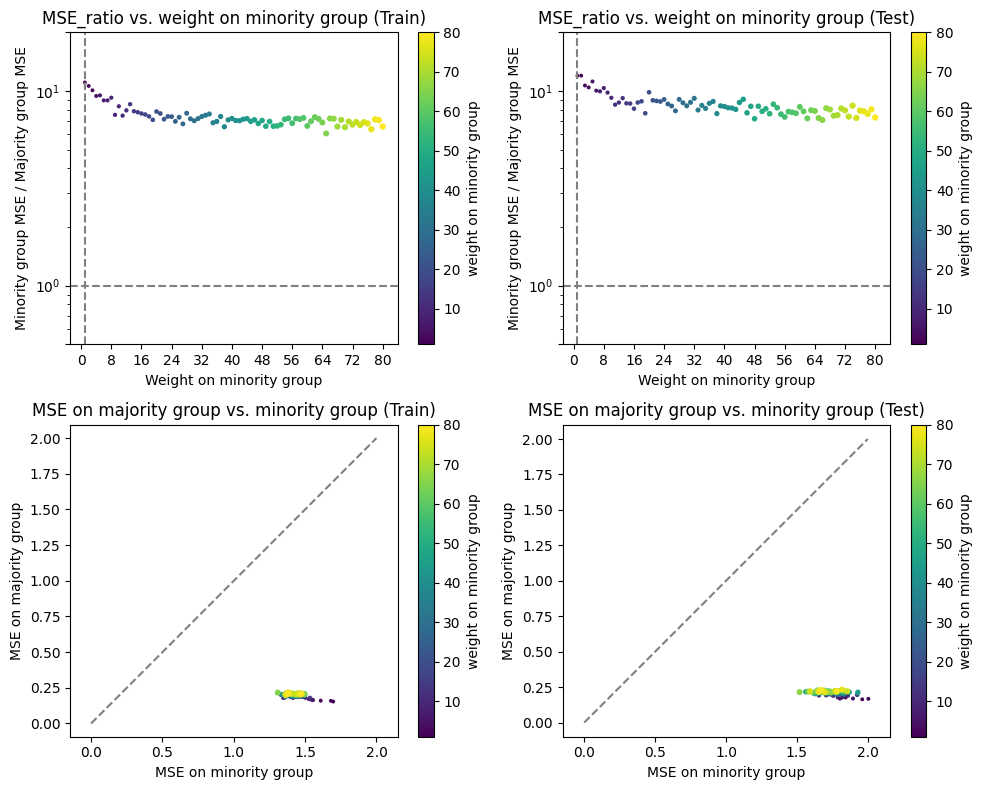

In [45]:
plot_MSE(mu_list, MSE_minority_train_list, MSE_majority_train_list, MSE_diff_train_list, 
         MSE_minority_test_list, MSE_majority_test_list, MSE_diff_test_list, 
         'smallP_locallinearTau_causalForest_MSEViz.png', custom_yticks = [5e-1, 1e0, 1e1, 2e1], max_MSE=2)
# custom_xticks=[i*8 for i in range(11)], custom_yticks=[i/2 for i in range(-1, 5, 1)], min_MSE=0, max_MSE=3)

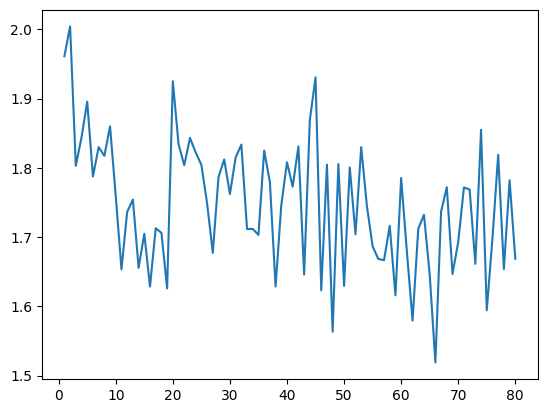

In [38]:
plt.plot(mu_list, MSE_minority_test_list)

In [39]:
MSE_minority_test_list

[1.9611205112746284,
 2.0040979124632345,
 1.8030359792896988,
 1.8438869324859641,
 1.8954670040454986,
 1.7875684189295913,
 1.8298719594297992,
 1.817328123796169,
 1.8597885641911671,
 1.7590434920360172,
 1.6534794129652928,
 1.7363774291082115,
 1.7541427746196376,
 1.6556040171708009,
 1.7048124507251396,
 1.6286272605209695,
 1.7128674062510447,
 1.7061772637850452,
 1.6259218433787819,
 1.9250731523828524,
 1.834146231966769,
 1.803802390806415,
 1.8432257793865838,
 1.822264423200151,
 1.804376724594372,
 1.7487663955171024,
 1.6772559013847421,
 1.7865287731738955,
 1.8121819804891783,
 1.7621849300515655,
 1.8148635208720032,
 1.8335479372830943,
 1.7116955460497618,
 1.7117587723178282,
 1.7031978477163114,
 1.824974313990273,
 1.7797481310358236,
 1.628582034571026,
 1.7461243796784924,
 1.8081538262810388,
 1.7727908599688311,
 1.8310261819216358,
 1.646035245650419,
 1.8688324963537346,
 1.9307408375383406,
 1.6230575499159574,
 1.8046716191255394,
 1.5634070919300354,


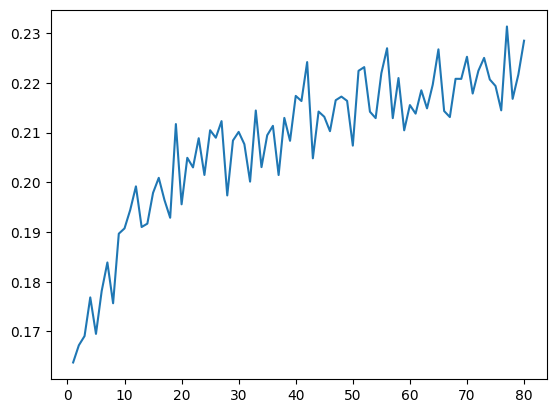

In [40]:
plt.plot(mu_list,MSE_majority_test_list)

In [41]:
MSE_majority_test_list

[0.16374637565430233,
 0.16720507395389006,
 0.16906238496037582,
 0.1768352507409762,
 0.1695015109237036,
 0.1781229679367705,
 0.1838639732046156,
 0.17565861927135848,
 0.18965543155849476,
 0.19072134188034398,
 0.19443640085367972,
 0.19918222219883983,
 0.19099845510051353,
 0.1916768436831593,
 0.19787245377789425,
 0.200892125839128,
 0.19642904540093334,
 0.19286144221409973,
 0.2117126102644402,
 0.19556736636220765,
 0.20492224204510545,
 0.20299189001735485,
 0.208868836374096,
 0.2014746894552782,
 0.21047014553869844,
 0.208966253956062,
 0.21230478009178455,
 0.19735273577780135,
 0.2084024289474837,
 0.21013723766729556,
 0.20766013298430316,
 0.20013169028793074,
 0.21444075611387334,
 0.20304828748115,
 0.20945981516207762,
 0.21135410779331995,
 0.20145976711510274,
 0.21295535536546878,
 0.20833752715423184,
 0.21737915101149724,
 0.2163446254323151,
 0.22418081630632616,
 0.20482088120278874,
 0.2142314418580465,
 0.21317569539926084,
 0.21027873444561798,
 0.2165

In [42]:
model = causalForest_estimator(X_train, W_train, Y_train)
model.feature_importances()

array([0.00000000e+00, 8.16158564e-03, 4.18797316e-04, 3.87504327e-01,
       5.96982186e-01, 6.93310427e-03])

In [43]:
model = causalForest_estimator(X_train, W_train, Y_train, weight_minority=20.0)
model.feature_importances()

array([0.        , 0.01601263, 0.00156123, 0.52743869, 0.43902416,
       0.01596328])

# WGAN Synthetic Data Augmentation

In [46]:
import pandas as pd

In [47]:
X_train, W_train, Tau_train, Y_train = gen_imbalanced_data_locallinearTE()
X_test, W_test, Tau_test, Y_test = gen_imbalanced_data_locallinearTE(n=1000)
# sanity check:
# shapes, should expect 4000x6, 4000, 4000, and 4000
print(X_train.shape, W_train.shape, Tau_train.shape, Y_train.shape)
# should expect numbers close to 0.01, 0.5, and 0
print(np.sum(X_train[:,0]) / len(X_train), np.sum(W_train) / len(W_train), np.sum(X_train[:,-1]) / len(X_train))
print("Some examples of Y:", Y_train[:5])

(4000, 6) (4000,) (4000,) (4000,)
0.009 0.48325 0.01699556173209566
Some examples of Y: [ 4.03653705 -0.26606868  1.53469595  5.96778767 -0.3156462 ]


In [48]:
train_concat = np.column_stack((np.array(W_train), np.array(X_train), np.array(Y_train)))
df_train = pd.DataFrame(train_concat, columns=['t', 'cat1', 'cat2', 'cat3', 'cont1', 'cont2', 'cont3', 'y'])

In [49]:
df_train.to_csv('df_smallp_train.csv', index=False)

In [50]:
df_generated = pd.read_csv("df_smallp_generated.csv")

In [51]:
df_generated.head()

,source,y,cont1,cont2,cont3,cat1,cat2,cat3,t,y_cf
0,fake,2.296727,0.137125,-0.082936,1.498344,0.0,0.0,0.0,0.0,1.523324
1,fake,-0.000951,1.142035,-1.363757,0.031673,0.0,1.0,0.0,0.0,1.041479
2,fake,1.651505,-0.050582,-1.815514,-0.762261,1.0,1.0,1.0,1.0,1.441770
3,fake,0.188994,-0.294365,1.155480,-0.973512,1.0,0.0,0.0,1.0,0.507235
4,fake,2.370828,1.008980,-0.214505,1.154180,0.0,0.0,1.0,0.0,5.017884


In [52]:
tau_generated = df_generated.cat1 + df_generated.cat2 + df_generated.cont1 + (1-df_generated.cat1) * df_generated.cont2

In [53]:
pred_generated = (df_generated.y - df_generated.y_cf)*df_generated.t + (df_generated.y_cf - df_generated.y)*(1-df_generated.t)

In [54]:
mean_squared_error(tau_generated, pred_generated) # that's very interesting, it's much worse than our CATE.

1.4866385942257925

In [55]:
np.corrcoef(tau_generated, pred_generated)[0, 1]

0.6990487368958513

## Synthetic Data Augmentation

In [57]:
def plot_MSE_aug(ratio_list, train_min, train_maj, train_diff, test_min, test_maj, test_diff, 
             name=None, custom_xticks=None, custom_yticks=None, min_MSE=0, max_MSE=1.0):
    
    plt.figure(figsize=(10,8))
    
    # plot ratio of MSE with respect to weight on minority (Train)
    plt.subplot(2, 2, 1)
    scatter_1 = plt.scatter(ratio_list, np.array(train_min) / np.array(train_maj), c=ratio_list, cmap='viridis', s=np.array(ratio_list)*8+3)
    plt.yscale('log')
    plt.colorbar(scatter_1, label='minority group size / majority group size')
    plt.axvline(x=1, color="grey", linestyle='--')
    plt.axhline(y=1.0, color="grey", linestyle='--')
    plt.xlabel('minority group size / majority group size')
    plt.ylabel('Minority group MSE / Majority group MSE')
    if custom_xticks is None:
        custom_xticks = [i/2 for i in range(11)] # Custom x-axis tick locations
    if custom_yticks is None:
        custom_yticks = [1e-1, 1e0, 1e1, 1e2] # Custom y-axis tick locations
    plt.xticks(custom_xticks)
    plt.yticks(custom_yticks)
    plt.title('MSE_ratio vs. minority group size (Train)')
    
    #  plot ratio of MSE with respect to weight on minority (Test)
    plt.subplot(2, 2, 2)
    scatter_2 = plt.scatter(ratio_list, np.array(test_min) / np.array(test_maj), c=ratio_list, cmap='viridis', s=np.array(ratio_list)*8+3)
    plt.yscale('log')
    plt.colorbar(scatter_2, label='minority group size / majority group size')
    plt.axvline(x=1, color="grey", linestyle='--')
    plt.axhline(y=1.0, color="grey", linestyle='--')
    plt.xlabel('minority group size / majority group size')
    plt.ylabel('Minority group MSE / Majority group MSE')
    if custom_xticks is None:
        custom_xticks = [i/2 for i in range(11)] # Custom x-axis tick locations
    if custom_yticks is None:
        custom_yticks = [1e-1, 1e0, 1e1, 1e2] # Custom y-axis tick locations
    plt.xticks(custom_xticks)
    plt.yticks(custom_yticks)
    plt.title('MSE_ratio vs. minority group size (Test)')
    
    # plot MSE on majority vs. on minority (Train)
    plt.subplot(2, 2, 3)
    # smaller circles indicate smaller weight
    scatter_3 = plt.scatter(train_min, train_maj, c=ratio_list, cmap='viridis', s=np.array(ratio_list)*8+3)
    plt.colorbar(scatter_3, label='minority group size / majority group size')
    plt.plot(np.linspace(min_MSE, max_MSE, 100), np.linspace(min_MSE, max_MSE, 100), linestyle='--', color='grey', label='45-Degree Line')
    plt.xlabel('MSE on minority group')
    plt.ylabel('MSE on majority group')
    plt.axis('equal')
    plt.title('MSE on majority group vs. minority group (Train)')
    
    # plot MSE on majority vs. on minority (Test)
    plt.subplot(2, 2, 4)
    # smaller circles indicate smaller weight
    scatter_4 = plt.scatter(test_min, test_maj, c=ratio_list, cmap='viridis', s=np.array(ratio_list)*4+3)
    plt.colorbar(scatter_4, label='minority group size / majority group size')
    plt.plot(np.linspace(min_MSE, max_MSE, 100), np.linspace(min_MSE, max_MSE, 100), linestyle='--', color='grey', label='45-Degree Line')
    plt.xlabel('MSE on minority group')
    plt.ylabel('MSE on majority group')
    plt.axis('equal')
    plt.title('MSE on majority group vs. minority group (Test)')
    
    plt.tight_layout()
    if name is not None:
        plt.savefig(name, dpi=200)
    plt.show()

In [58]:
# df_generated = pd.read_csv("df_generated_noBalance/df_generated_noBalance.csv")
df_generated = pd.read_csv("df_smallp_generated.csv")

In [59]:
df_generated_minority = df_generated[df_generated["cat1"] == 1]

In [60]:
df_generated_minority.shape

(462454, 10)

Try finer detail increments and run multiple times to get an average, also label the points with the amount of synthetic data added if possible

In [65]:
ratio_list = []
MSE_minority_train_list, MSE_majority_train_list, MSE_diff_train_list = [], [], []
MSE_minority_test_list, MSE_majority_test_list, MSE_diff_test_list = [], [], []
num_min = np.sum(X_train[:,0] == 1)
num_maj = np.sum(X_train[:,0] == 0)
assert(num_min + num_maj == 4000)

start_time = time.time()
for i in range(51):
    # everytime add 80 more minority data point to training set
    ratio_list.append((num_min+i*80)/num_maj)

    MSE_minority_train_temp, MSE_majority_train_temp, MSE_diff_train_temp = [], [], []
    MSE_minority_test_temp, MSE_majority_test_temp, MSE_diff_test_temp = [], [], []
    for j in range(NUM_SIMULATIONS):
        if i != 0:
            df_sampled = df_generated_minority.sample(80*i)
            X = np.vstack((X_train,df_sampled[["cat1","cat2","cat3","cont1","cont2","cont3"]].values))
            W = np.hstack((W_train,df_sampled["t"].values))
            Y = np.hstack((Y_train,df_sampled["y"].values))
        else:
            X = X_train
            W = W_train
            Y = Y_train
        model = causalForest_estimator(X, W, Y)
        # eval on train data
        CATE_pred = model.predict(X_train)[:,0]
        MSE_minority, MSE_majority, MSE_diff = eval_MSE_twoGroups(CATE_pred, X_train, Tau_train)
        MSE_minority_train_temp.append(MSE_minority)
        MSE_majority_train_temp.append(MSE_majority)
        MSE_diff_train_temp.append(MSE_diff)
        # eval on test data
        CATE_pred = model.predict(X_test)[:,0]
        MSE_minority, MSE_majority, MSE_diff = eval_MSE_twoGroups(CATE_pred, X_test, Tau_test)
        MSE_minority_test_temp.append(MSE_minority)
        MSE_majority_test_temp.append(MSE_majority)
        MSE_diff_test_temp.append(MSE_diff)
    
    MSE_minority_train_list.append(np.mean(MSE_minority_train_temp))
    MSE_majority_train_list.append(np.mean(MSE_majority_train_temp))
    MSE_diff_train_list.append(np.mean(MSE_diff_train_temp))
    
    MSE_minority_test_list.append(np.mean(MSE_minority_test_temp))
    MSE_majority_test_list.append(np.mean(MSE_majority_test_temp))
    MSE_diff_test_list.append(np.mean(MSE_diff_test_temp))
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 3593.3860239982605 seconds ---


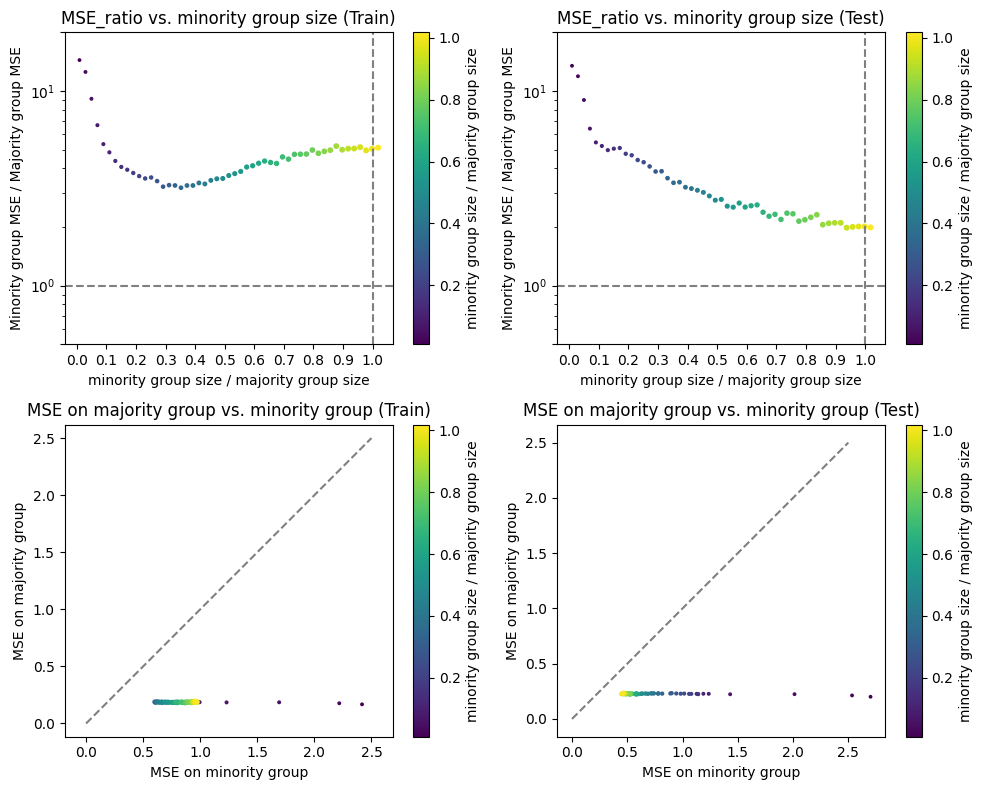

In [67]:
plot_MSE_aug(ratio_list, MSE_minority_train_list, MSE_majority_train_list, MSE_diff_train_list, 
         MSE_minority_test_list, MSE_majority_test_list, MSE_diff_test_list, 
         'smallp_causalForest_WGANAug_MSEViz.png',
         custom_xticks=[i/10 for i in range(0, 11, 1)], custom_yticks = [5e-1, 1e0, 1e1, 2e1], max_MSE = 2.5)

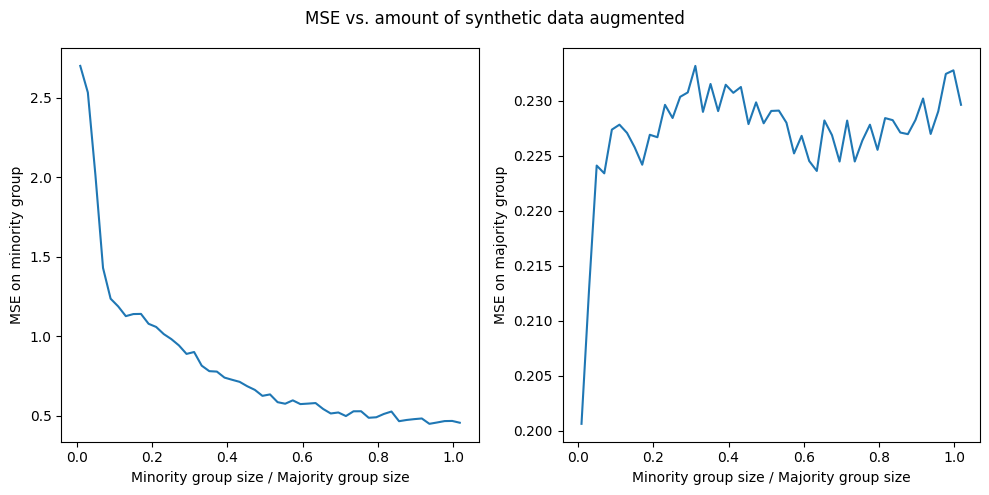

In [70]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(ratio_list, MSE_minority_test_list)

idx = 13
x_first_half, y_first_half = ratio_list[:idx], MSE_minority_test_list[:idx]
x_second_half, y_second_half = ratio_list[idx:], MSE_minority_test_list[idx:]

# Fitting lines to the first and second halves of the data
coefficients_first_half, cov_first_half = np.polyfit(x_first_half, y_first_half, 1, cov=True)
coefficients_second_half, cov_second_half = np.polyfit(x_second_half, y_second_half, 1, cov=True)

# Generating the line equations
line_first_half = np.poly1d(coefficients_first_half)
line_second_half = np.poly1d(coefficients_second_half)

# Extracting standard deviation from the covariance matrix
std_dev_first_half = np.sqrt(np.diag(cov_first_half))[0]
std_dev_second_half = np.sqrt(np.diag(cov_second_half))[0]

# Plotting the lines of best fit for the first and second halves
color='#333333'
# plt.plot(x_first_half, line_first_half(x_first_half), label=f'Before 0.4: β = {coefficients_first_half[0]:.2f} ({std_dev_first_half:.2f})', linestyle = '--', color=color)
# plt.plot(x_second_half, line_second_half(x_second_half), label=f'After 0.4: β = {coefficients_second_half[0]:.2f} ({std_dev_second_half:.2f})', linestyle = '-.', color=color)
# plt.axvline(x=mu_list[idx], color='black', linestyle='-.')

# Adding text above each line with the beta coefficient
# plt.text((1+1+idx / 4)/2, line_first_half((1+1+idx / 4)/2)-10, f'slope: {coefficients_first_half[0]:.2f} ({std_dev_first_half:.2f})', fontsize=10, ha='center', color=color)
# plt.text((12+1+idx / 4)/2, line_second_half((12+1+idx / 4)/2)-10, f'slope: {coefficients_second_half[0]:.2f} ({std_dev_second_half:.2f})', fontsize=10, ha='center', color=color)

# plt.xticks([1.5,3.0,4.5,6,7.5,9,10.5,12])
# plt.legend()
plt.xlabel('Minority group size / Majority group size')
plt.ylabel('MSE on minority group')

# second plot for majority
plt.subplot(1, 2, 2)
plt.plot(ratio_list, MSE_majority_test_list)

idx = 13
x_first_half, y_first_half = ratio_list[:idx], MSE_majority_test_list[:idx]
x_second_half, y_second_half = ratio_list[idx:], MSE_majority_test_list[idx:]

# Fitting lines to the first and second halves of the data
coefficients_first_half, cov_first_half = np.polyfit(x_first_half, y_first_half, 1, cov=True)
coefficients_second_half, cov_second_half = np.polyfit(x_second_half, y_second_half, 1, cov=True)

# Generating the line equations
line_first_half = np.poly1d(coefficients_first_half)
line_second_half = np.poly1d(coefficients_second_half)

# Extracting standard deviation from the covariance matrix
std_dev_first_half = np.sqrt(np.diag(cov_first_half))[0]
std_dev_second_half = np.sqrt(np.diag(cov_second_half))[0]

# Plotting the lines of best fit for the first and second halves
color='#333333'
# plt.plot(x_first_half, line_first_half(x_first_half), label=f'Before 0.4: β = {coefficients_first_half[0]:.2f} ({std_dev_first_half:.2f})', linestyle = '--', color=color)
# plt.plot(x_second_half, line_second_half(x_second_half), label=f'After 0.4: β = {coefficients_second_half[0]:.2f} ({std_dev_second_half:.2f})', linestyle = '-.', color=color)
# plt.axvline(x=mu_list[idx], color='black', linestyle='-.')

# plt.xticks([1.5,3.0,4.5,6,7.5,9,10.5,12])
# plt.legend()
plt.xlabel('Minority group size / Majority group size')
plt.ylabel('MSE on majority group')

fig.suptitle('MSE vs. amount of synthetic data augmented') #  fontsize=16, y=1.05
plt.tight_layout()
plt.savefig("smallp_MSE_augratio_best_fit", dpi=200)
plt.show()


### End of Notebook

In [ ]:
print("--- %s seconds ---" % (time.time() - global_start_time))